<a href="https://colab.research.google.com/github/eduardoplima/rl-imd/blob/main/Q_learning_SARSA_Tabular_FrozenLaken.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular Q-learning and SARSA for Frozen Lake

In this notebook, we will use Q-learning and SARSA methods to solve Frozen Lake.


Environment: (https://gymnasium.farama.org/environments/toy_text/frozen_lake/).

##Setup

In [1]:
%%capture
!pip install gymnasium
!pip install numpy
!pip install imageio imageio_ffmpeg
!pip install pyvirtualdisplay
!apt-get install -y xvfb
!apt-get install -y python-opengl ffmpeg

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Setup a Virtual Display
To generate a replay video of agent and environment.

In [ ]:
# Virtual display
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [ ]:
from gym.envs.toy_text.frozen_lake import generate_random_map

# Let's start by creating the Frozen Lake environment.
side_map_size = 8
proba_frozen = 0.9

env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="rgb_array", desc=generate_random_map(size=side_map_size, p=proba_frozen))
env.spec

EnvSpec(id='FrozenLake-v1', entry_point='gymnasium.envs.toy_text.frozen_lake:FrozenLakeEnv', reward_threshold=0.7, nondeterministic=False, max_episode_steps=100, order_enforce=True, disable_env_checker=False, kwargs={'map_name': '4x4', 'is_slippery': False, 'render_mode': 'rgb_array', 'desc': ['SFFFFFFF', 'FFFFFHFF', 'FFFFFFFF', 'HFFFFFFF', 'FFFHFFFF', 'FHFFFFHF', 'FFFFFFFH', 'FFFFFFFG']}, namespace=None, name='FrozenLake', version=1, additional_wrappers=(), vector_entry_point=None)

##Observing the environment

In [ ]:
# actions: move left=0, move down = 1, move right = 2, move up = 3
actions = ["move left", "move down", "move right", "move up"]
print ("Actions:", actions)

Actions: ['move left', 'move down', 'move right', 'move up']


In [ ]:
def plot_image(plot, render, size):
  plot.figure(figsize=(14, 5))
  plot.xticks(range(size))
  plot.yticks(range(size))
  plot.imshow(render, extent=[0, size, size, 0])
  plot.show()

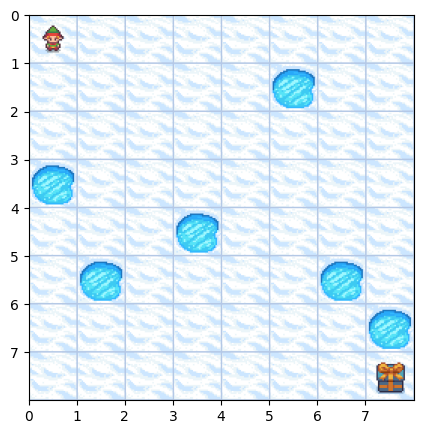

In [ ]:
# This sets the initial state at S, our starting point
# We can render the environment to see where we are on the frozenlake gridworld
env.reset()
img = env.render()
plot_image(plt,img,int(np.sqrt(env.observation_space.n)))

##Executing random actions

In [ ]:
# Taking a step by selecting a random action[move left=0, move down = 1, move right = 2, move up = 3] from current state
# next_observation: position on the grid
# reward: What rewards did I receive?
# is_terminal: did I end up in the goal state?

print("step number : action, position, reward, terminated, truncated, {info}")

for i in range(20):
    # sample a random action from all valid actions
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    print("step", i+1, ":", action, ",", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
    if(is_terminal):
        break

step number : action, position, reward, terminated, truncated, {info}
step 1 : 1 , move down , 8 , 0.0 , False , False , {'prob': 1.0}
step 2 : 1 , move down , 16 , 0.0 , False , False , {'prob': 1.0}
step 3 : 1 , move down , 24 , 0.0 , True , False , {'prob': 1.0}


In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)

# returns an initial observation
state, info = env.reset()
env.render()
video.capture_frame()

for i in range(100):
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    env.render()
    video.capture_frame()

    if(is_terminal):
        print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
        break

video.close()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 62 : move right , 35 , 0.0 , True , False , {'prob': 1.0}


In [ ]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

##Building a Q-learning agent (off-policy) or a SARSA agent (on-policy)

![QL](https://github.com/dudeperf3ct/RL_Notebooks/blob/master/TD/images/ql.png?raw=1)
![QL](https://github.com/dudeperf3ct/RL_Notebooks/blob/master/TD/images/sarsa.png?raw=1)

In [ ]:
class FrozenLakeAgent:

    def __init__(
        self,
        alpha_learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        gamma_discount_factor: float,
        state_size: int,
        action_size: int,
        is_using_Sarsa: bool
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_table), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_size: The state space
            action_size: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_size = state_size
        self.action_size = action_size
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []
        self.q_table = np.zeros((self.state_size, self.action_size))

        if(self.is_using_Sarsa):
            print("Using Sarsa method")
        else:
            print("Using Q-learning method")

        # Set the seed
        self.rng = np.random.default_rng(123)

    def get_Q_Table(self):
        return self.q_table

    def eval_state(self, state):
        # Break ties randomly
        # Find the indices where the Q-value equals the maximum value
        # Choose a random action from the indices where the Q-value is maximum
        max_ids = np.where(self.q_table[state, :] == np.max(self.q_table[state, :]))[0]
        return self.rng.choice(max_ids)

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return env.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return self.eval_state(state)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
        next_action: int
    ):
        """Updates the Q-value of an action."""
        if terminated:
            target = reward
        else:
            # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
            if(self.is_using_Sarsa):
                target = reward + self.gamma_discount_factor * self.q_table[next_state, next_action]

            # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            else:
                target = reward + self.gamma_discount_factor * np.max(self.q_table[next_state, :])

        temporal_difference_error = target - self.q_table[state, action]

        # Train the agent using target and the predicted q_table values
        self.q_table[state, action] = self.q_table[state, action] + self.alpha_learning_rate * temporal_difference_error

        self.training_error.append(temporal_difference_error)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

## Hyperparameters

In [ ]:
# hyperparameters
alpha_learning_rate = 0.5 # @param {type:"number"}
nb_max_episodes = 5000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes # reduce the exploration over time
gamma_discount_factor = 0.95 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

agent = FrozenLakeAgent(
    alpha_learning_rate=alpha_learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma_discount_factor=gamma_discount_factor,
    state_size = env.observation_space.n,
    action_size = env.action_space.n,
    is_using_Sarsa = is_using_Sarsa
)

Using Q-learning method


### Test accurracy

In [ ]:
def test_accurracy(num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

In [ ]:
def record_trained_video(video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()

## Playing and Training

In [ ]:
from tqdm import tqdm
#Create lists to contain total rewards, steps and accurracy per episode
accuracies = []
mean_rewards = []
rewards = []
steps = []

for episode_count in tqdm(range(nb_max_episodes)):
    state, info = env.reset()
    is_terminal = False
    total_reward = 0
    episode_step = 0

    if(is_using_Sarsa): # Sarsa
        # Choose an action by greedily (with epsilon chance of random action) from the Q-Table
        action = agent.choose_action(state)

    # The Q-Table training
    while not is_terminal:
        episode_step += 1

        if(not is_using_Sarsa): # Q-learning
            # Choose an action by greedily (with epsilon chance of random action) from the Q-Table
            action = agent.choose_action(state)

        # Play best or random move and get new state and reward from environment
        next_state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        # update the agent
        if(not is_using_Sarsa): # Q-learning
            agent.update(state, action, reward, terminated, next_state, None)
        else: # Sarsa
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, terminated, next_state, next_action)
            action = next_action

        # update the current observation
        state = next_state
        total_steps += 1
        total_reward += reward

    agent.decay_epsilon()

    mean_rewards.append(total_reward)
    if (episode_count+1) % test_freq == 0:
        accur = test_accurracy(env.spec.max_episode_steps,50)
        accuracies.append(accur)

        print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
        mean_rewards.clear()

    rewards.append(total_reward)
    steps.append(episode_step)

after_training = "after_training.mp4"
record_trained_video(after_training, env.spec.max_episode_steps)
env.close()

  4%|▍         | 189/5000 [00:00<00:10, 472.84it/s]

step: 2727, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49199999999999755


  6%|▌         | 286/5000 [00:00<00:12, 380.54it/s]

step: 5379, episode: 200, accuracy training: 0.0, accuracy test: 0.02, random move probability: 0.4839999999999951


  8%|▊         | 378/5000 [00:00<00:12, 367.51it/s]

step: 8396, episode: 300, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.47599999999999265


  9%|▉         | 468/5000 [00:01<00:12, 353.46it/s]

step: 11013, episode: 400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4679999999999902


 11%|█         | 541/5000 [00:01<00:15, 287.63it/s]

step: 13795, episode: 500, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.45999999999998775


 13%|█▎        | 668/5000 [00:02<00:15, 288.58it/s]

step: 16441, episode: 600, accuracy training: 0.01, accuracy test: 0.02, random move probability: 0.4519999999999853


 15%|█▍        | 742/5000 [00:02<00:14, 297.69it/s]

step: 19319, episode: 700, accuracy training: 0.03, accuracy test: 0.02, random move probability: 0.44399999999998285


 18%|█▊        | 881/5000 [00:02<00:11, 374.33it/s]

step: 22061, episode: 800, accuracy training: 0.24, accuracy test: 1.0, random move probability: 0.4359999999999804


 20%|█▉        | 990/5000 [00:02<00:08, 456.81it/s]

step: 24402, episode: 900, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.42799999999997795
step: 26639, episode: 1000, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.4199999999999755

 22%|██▏       | 1100/5000 [00:03<00:08, 465.55it/s]


step: 28618, episode: 1100, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.41199999999997305


 26%|██▌       | 1300/5000 [00:03<00:07, 503.72it/s]

step: 30628, episode: 1200, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4039999999999706
step: 32667, episode: 1300, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.39599999999996816


 29%|██▉       | 1473/5000 [00:03<00:06, 539.12it/s]

step: 34583, episode: 1400, accuracy training: 0.58, accuracy test: 1.0, random move probability: 0.3879999999999657


 32%|███▏      | 1590/5000 [00:03<00:06, 517.49it/s]

step: 36489, episode: 1500, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.37999999999996326


 34%|███▍      | 1700/5000 [00:04<00:07, 470.64it/s]

step: 38556, episode: 1600, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3719999999999608
step: 40561, episode: 1700, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.36399999999995836


 38%|███▊      | 1878/5000 [00:04<00:06, 512.62it/s]

step: 42530, episode: 1800, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.3559999999999559
step: 44350, episode: 1900, accuracy training: 0.53, accuracy test: 1.0, random move probability: 0.34799999999995346


 42%|████▏     | 2100/5000 [00:04<00:04, 590.42it/s]

step: 46240, episode: 2000, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.339999999999951
step: 48162, episode: 2100, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.33199999999994856


 46%|████▌     | 2300/5000 [00:05<00:03, 733.48it/s]

step: 49981, episode: 2200, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3239999999999461
step: 51815, episode: 2300, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.31599999999994366


 50%|█████     | 2500/5000 [00:05<00:02, 836.46it/s]

step: 53515, episode: 2400, accuracy training: 0.6, accuracy test: 1.0, random move probability: 0.3079999999999412
step: 55306, episode: 2500, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.29999999999993876


 54%|█████▍    | 2700/5000 [00:05<00:02, 820.62it/s]

step: 57138, episode: 2600, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.2919999999999363
step: 58970, episode: 2700, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.28399999999993386


 58%|█████▊    | 2898/5000 [00:05<00:02, 877.96it/s]

step: 60736, episode: 2800, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.2759999999999314
step: 62521, episode: 2900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.26799999999992896


 63%|██████▎   | 3164/5000 [00:06<00:02, 865.39it/s]

step: 64283, episode: 3000, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2599999999999265
step: 66005, episode: 3100, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.25199999999992406


 67%|██████▋   | 3348/5000 [00:06<00:01, 894.41it/s]

step: 67754, episode: 3200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.24399999999992372
step: 69385, episode: 3300, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.23599999999992405


 71%|███████   | 3527/5000 [00:06<00:01, 857.57it/s]

step: 70996, episode: 3400, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.22799999999992437
step: 72740, episode: 3500, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.2199999999999247


 74%|███████▍  | 3707/5000 [00:06<00:01, 873.22it/s]

step: 74300, episode: 3600, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.21199999999992503
step: 75942, episode: 3700, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.20399999999992535


 78%|███████▊  | 3900/5000 [00:07<00:01, 847.84it/s]

step: 77544, episode: 3800, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.19599999999992568
step: 79116, episode: 3900, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.187999999999926


 82%|████████▏ | 4100/5000 [00:07<00:01, 896.60it/s]

step: 80743, episode: 4000, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.17999999999992633
step: 82323, episode: 4100, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.17199999999992666


 86%|████████▌ | 4300/5000 [00:07<00:00, 901.15it/s]

step: 83949, episode: 4200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.16399999999992698
step: 85562, episode: 4300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1559999999999273


 90%|█████████ | 4500/5000 [00:07<00:00, 896.87it/s]

step: 87126, episode: 4400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.14799999999992763
step: 88679, episode: 4500, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.13999999999992796


 94%|█████████▍| 4700/5000 [00:07<00:00, 890.40it/s]

step: 90175, episode: 4600, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.13199999999992829
step: 91680, episode: 4700, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.12399999999992861


 98%|█████████▊| 4901/5000 [00:08<00:00, 937.32it/s]

step: 93161, episode: 4800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.11599999999992894
step: 94668, episode: 4900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.10799999999992926


100%|██████████| 5000/5000 [00:08<00:00, 609.47it/s]
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 96159, episode: 5000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1
step 14 : move right , 63 , 1.0 , True , False , {'prob': 1.0}


In [ ]:
# You should get a video similar to the one below.
html = render_mp4(after_training)
HTML(html)

### Metrics

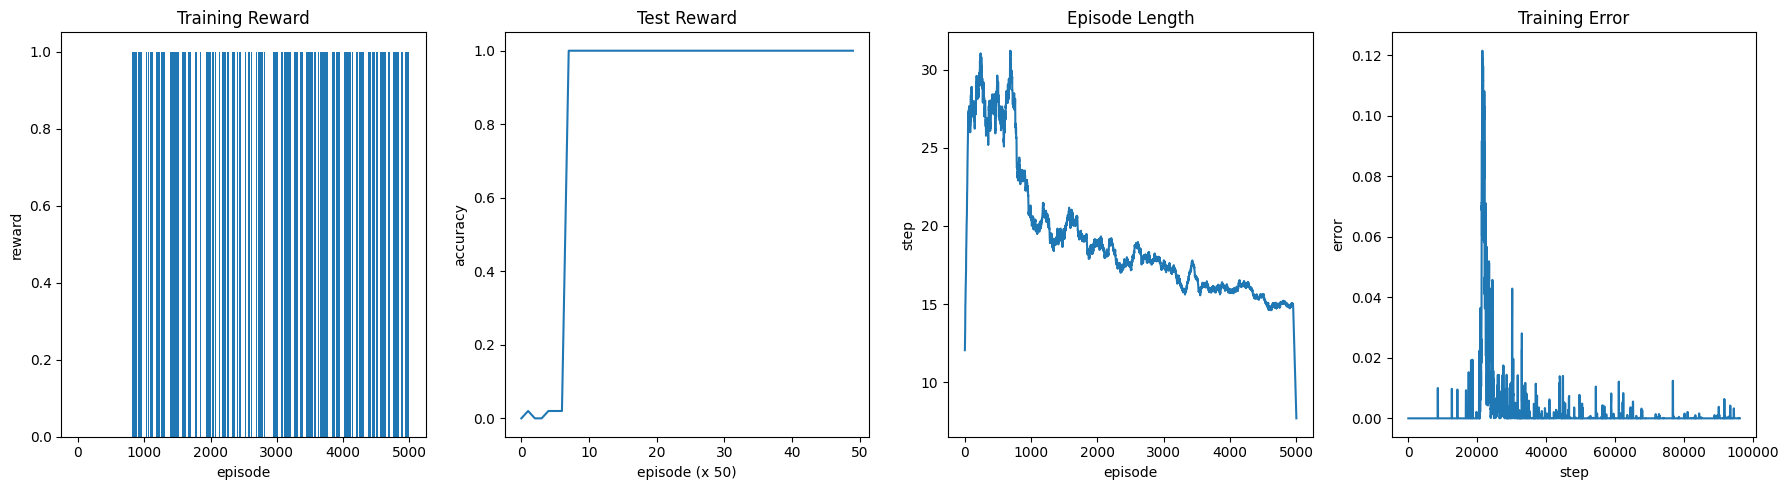

In [ ]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [ ]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [ ]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

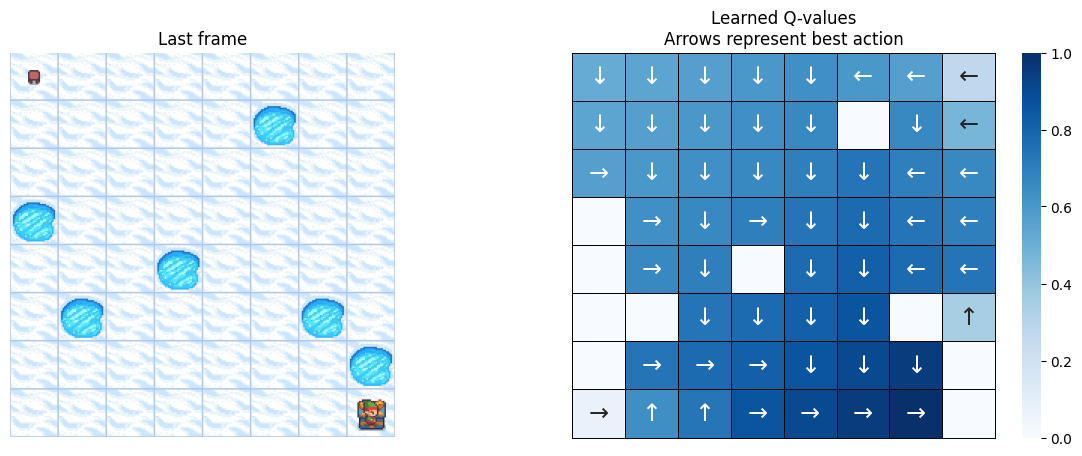

In [ ]:
plot_q_values_map(agent.get_Q_Table(), env, side_map_size)